In [1]:
import os
from pathlib import Path
from tqdm.notebook import tqdm
from itertools import accumulate
from collections import Counter

import numpy as np
import pandas as pd

from utils import *

import plotly.graph_objects as go

import dash
from dash import dcc
from dash import html

# OKVQA - data investigations

This notebook examines the OKVQA dataset. Both images and questions will be analyzed. 

## 1) Load data
We start by loading the OKVQA datasets downloaded through [MMF](https://github.com/facebookresearch/mmf).


In [2]:
# data load function
def loadData(filename, data_path):
    data = np.load(data_path / filename, allow_pickle=True)
    dataset_specs = data[0]
    
    print("Dataset specs:")
    for key, value in dataset_specs.items():
        print(f"{key}: {value}")
    
    return pd.DataFrame.from_records(data[1:])

In [3]:
# path to dataset
data_path = Path.home() / '.cache/torch/mmf/data/datasets/okvqa/defaults/annotations/annotations'
filenames = ['imdb_train.npy', 'imdb_test.npy', 'imdb_val.npy', 'imdb_trainval.npy']

alberts_sisters_computer = True
if alberts_sisters_computer:
    data_path = Path('/Users/Olivia/Desktop/albert/data')

okvqa = {}
for filename in filenames:
    print(f"{'-'*50}\nLoading {filename}...\n")
    name = filename.split('.')[0].split('_')[1]
    okvqa[name] = loadData(filename, data_path)

--------------------------------------------------
Loading imdb_train.npy...

Dataset specs:
create_time: 2020-09-03 13:40:00.451863
dataset_name: okvqa
version: 1.1
has_answer: True
has_gt_layout: False
created_at: 1599165600.4518836
--------------------------------------------------
Loading imdb_test.npy...

Dataset specs:
create_time: 2020-09-03 13:39:59.718679
dataset_name: okvqa
version: 1.1
has_answer: True
has_gt_layout: False
created_at: 1599165599.718699
--------------------------------------------------
Loading imdb_val.npy...

Dataset specs:
create_time: 2020-09-03 13:40:00.642192
dataset_name: okvqa
version: 1.1
has_answer: True
has_gt_layout: False
created_at: 1599165600.6422124
--------------------------------------------------
Loading imdb_trainval.npy...

Dataset specs:
create_time: 2020-09-03 13:40:00.072816
dataset_name: okvqa
version: 1.1
has_answer: True
has_gt_layout: False
created_at: 1599165600.0728385


## 2) Initial investigation

As given by the creators of the [OKVQA dataset](https://okvqa.allenai.org/), there are 14,055 open-ended questions in the dataset. Let's figure out how this relates to the data that we just loaded...

In [4]:
okvqa['train'].shape[0] + okvqa['test'].shape[0] + okvqa['val'].shape[0] + okvqa['trainval'].shape[0]

23064

This is much larger than what is stated by the creators of the OKVQA dataset. But wait a second... One of the datafiles provided by MMF is called `imdb_trainval.npy` - what happens if we ignore this?

In [5]:
okvqa['train'].shape[0] + okvqa['test'].shape[0] + okvqa['val'].shape[0]

14055

Alright! So the trainval is probably just a combination of the training and validation data - let's quickly verify this...

In [6]:
okvqa['train'].shape[0] + okvqa['val'].shape[0] == okvqa['trainval'].shape[0]

True

Indeed that is true! Let's ignore the `imdb_train.npy` and `imdb_trainval.npy` files and inspect the training data as the mix of these and compare it to the test data.

In [7]:
okvqa_full = pd.concat([okvqa['trainval'], okvqa['test']]).reset_index().drop('index', axis=1)

print(f"Shape of dataframe: {okvqa_full.shape}")
okvqa_full.head()

Shape of dataframe: (14055, 9)


,image_id,question_id,question_str,question_tokens,all_answers,answers,image_name,feature_path,ocr_tokens
0,51606,516065,What is the hairstyle of the blond called?,"[what, is, the, hairstyle, of, the, blond, cal...","[pony tail, pony tail, pony tail, pony tail, p...","[pony tail, pony tail, pony tail, pony tail, p...",COCO_train2014_000000051606,COCO_train2014_000000051606.npy,[]
1,81721,817215,How old do you have to be in canada to do this?,"[how, old, do, you, have, to, be, in, canada, ...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]",COCO_train2014_000000081721,COCO_train2014_000000081721.npy,[]
2,480208,4802085,Can you guess the place where the man is playing?,"[can, you, guess, the, place, where, the, man,...","[aspen, aspen, mountain, mountain, mountain, m...","[aspen, aspen, mountain, mountain, mountain, m...",COCO_train2014_000000480208,COCO_train2014_000000480208.npy,[]
3,570618,5706185,Which rail company is named after a town in ne...,"[which, rail, company, is, named, after, a, to...","[santa fe, santa fe, santa fe, santa fe, new e...","[santa fe, santa fe, santa fe, santa fe, new e...",COCO_train2014_000000570618,COCO_train2014_000000570618.npy,[]
4,478903,4789035,Is the boy swimming or doing another water act...,"[is, the, boy, swimming, or, doing, another, w...","[another activity, another activity, another a...","[another activity, another activity, another a...",COCO_train2014_000000478903,COCO_train2014_000000478903.npy,[]


## 2) Question and Answers



Let's look at the questions of the dataset. It is evident that 3 attributes are associated to the questions, namely `question_id`, `question_str` and `question_tokens`. `question_id` is used within the MMF framework to call for specific image/question pairs and they are thus unique. `question_str` (and hence `question_tokens`) are not..

In [8]:
print(f"question id's unique? {okvqa_full.question_id.is_unique}")
print(f"question strings unique? {okvqa_full.question_str.is_unique}")

question id's unique? True
question strings unique? False


Going one step further, we analyze the textual content of the question data. Let's start looking at the start words of the question as they can be considered kind of representatives of the complexity of the questions.

In [9]:
def investigate_this(anonymous_function, data_attribute: pd.Series, what=False):
    counter = Counter(data_attribute.apply(anonymous_function))
    attr, freqs = list(zip(*sorted(counter.items(), key=lambda x: x[1], reverse=True)))
    if type(attr[0]) == int:
        datalist = pd.Series(np.concatenate([[attr[i]]*freq for (i, freq) in enumerate(freqs)]))
    else:
        datalist = pd.Series(np.concatenate([[i]*freq for (i, freq) in enumerate(freqs)]))
    
    if what != False:
        print(f"Number of {what}: {attr.__len__()}")
    
        #from utils import LogAndLinearHist
        LogAndLinearHist(datalist, xlabel='')
    
    # ccompute percentages
    percentage = pd.DataFrame({'attribute':attr, 'percentage':np.array(freqs)/sum(freqs)*100})
    datalist = pd.Series(np.concatenate([[attr[i]]*freq for (i, freq) in enumerate(freqs)]))
    
    return datalist, percentage


Number of unique start words: 164


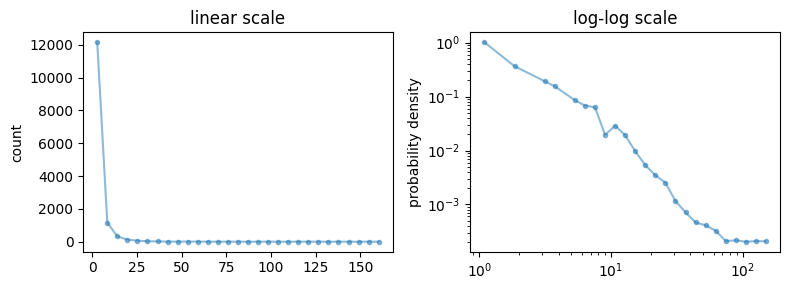

,start word,percentage
0,what,66.040555
1,how,6.623977
2,is,4.034152
3,where,3.600142
4,which,3.464959
5,who,2.710779
6,why,2.575596
7,the,1.465671
8,name,1.394522
9,when,1.045891


In [10]:
start_words, percentage = investigate_this(lambda x: x[0], okvqa_full.question_tokens, what='unique start words')

# modify dataframe
percentage.rename(columns={'attribute':'start word'}, inplace=True)
percentage[percentage.percentage.cumsum() < 97.5]

Analyzing the occurrence frequency on histograms, we see that the distribution is quite like a power law, since it is kind of linear on the log-log plot. This means that many of the first occuring words are quite rare and that some words occur very frequently. It turns out that these high-occuring words only consist of one word and that the 97.5% most occuring words amounts to 17 words.

Complexity of questions can be defined in various ways, but one way is to look at the answers. Another way is to look at the questions themselves. So how do we do it best?

We suggest analyzing the question complexity in various ways to get a more holistic understanding of the complexity of the questions in the dataset:
> 1) question length (number of words) \
> 2) answer length (number of words) \
> 3) count the amount of non-agreeing answers to each question and use this as a proxy for complexity. \

Let's begin by looking at number 1).

Number of various question lengths: 27


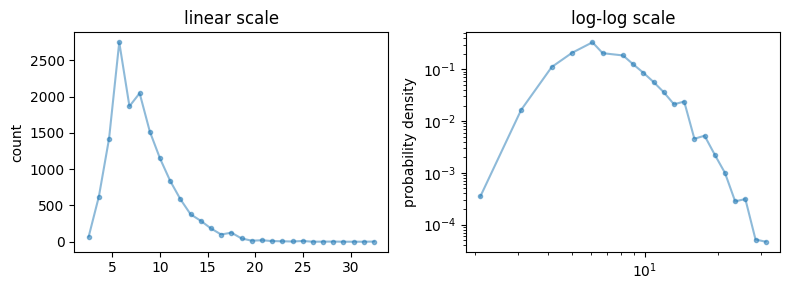

,question_length,percentage
26,2,0.007115
14,3,0.490928
7,4,4.425471
4,5,10.110281
0,6,19.565991
2,7,13.290644
1,8,14.571327
3,9,10.807542
5,10,8.167912
6,11,5.962291


In [11]:
question_length, percentage = investigate_this(lambda x: x.__len__(), okvqa_full.question_tokens, what='various question lengths')

# modify dataframe
percentage.rename(columns={'attribute':'question_length'}, inplace=True)
percentage.sort_values(by='question_length')

In [12]:
question_length.describe()

count    14055.000000
mean         8.180576
std          2.996817
min          2.000000
25%          6.000000
50%          8.000000
75%         10.000000
max         33.000000
dtype: float64

We observe that there are a total of 14055 questions that vary between having a length of 2 and 33 tokens. The mean and median are both quite similar around 8 tokens per question but are a bit right-skewed which is why the histogram on the linear plot also is a bit right-skewed.

An initial thought about this is, that the questions seem to be of a specific type in terms of question length complexity. There are however some questions that are super long, which would probably increase the complexity drastically due to ambiguity but there are also less complex questions of length 2.

Then what about the answers? Let's start by getting the basics about them - it turns out that each question has 10 answers.

In [13]:
# number of answers
okvqa_full.answers.apply(lambda x: x.__len__()) 

0        10
1        10
2        10
3        10
4        10
         ..
14050    10
14051    10
14052    10
14053    10
14054    10
Name: answers, Length: 14055, dtype: int64

In [14]:
(okvqa_full.answers.apply(lambda x: x.__len__()) == 10).all()

True

With respect to the answers (complexity investigation 2) ), we average the answer length of the 10 answers for each question, since they might differ in length. Then we use this as the descriptive stat for our descriptive investigation.

Number of observed differences in avg. answer length: 20


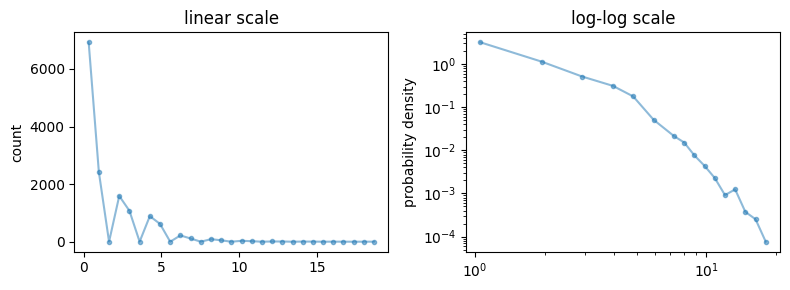

Average answer length lower than two = 91.725


,answer_length,percentage
0,1.0,49.263607
1,1.2,17.203842
2,1.4,11.305585
3,1.6,7.634294
4,1.8,6.318036
5,2.0,4.397012
6,2.2,1.551049
7,2.4,0.796869
8,2.6,0.626112
9,2.8,0.348630


In [15]:
answer_length, percentage = investigate_this(lambda answer: np.mean([subanswer.split(" ").__len__() for subanswer in answer]), okvqa_full.answers, what='observed differences in avg. answer length')

# modify dataframe
percentage.rename(columns={'attribute':'answer_length'}, inplace=True)
print(f"Average answer length lower than two = {percentage[percentage.answer_length < 2].percentage.sum():.3f}")
percentage.sort_values(by='answer_length')

In [16]:
answer_length.describe()

count    14055.000000
mean         1.279360
std          0.398017
min          1.000000
25%          1.000000
50%          1.200000
75%          1.400000
max          7.200000
dtype: float64

With 19 different average answer lengths, we obseve that the average answer length is in general quite low. It is observable from the percentage dataframe, that around 92% of the answers (including variability) consists of single words. There are however questions, that have an average answer length of 7.2. With this distribution of average answer lengths that follows a power law, it seems like the questions are rather simple as most of them are answerable with a single word. This, however, could also be due to an experimental bias, where answers given by the human annotators, have been pruned to their essential parts - either while doing the collection or as a post-processing such that determiner words are removed to solely keep the important content of the answers. In other words - the human annotators might have been told to keep their answers short and to the point, in order to not need a text generation module creating long sequences with SOTA performances to answer the questions.

We'll get back to the outliers (long answers) later... Let's first dig into the fact that the responses on a question might differ. We call this the answer variability and compute the number of different answers for each question as another metric for understanding question complexity.

In [17]:
# variety in answers
answer_variety = okvqa_full.answers.apply(lambda x: np.unique(x).__len__())
counter = Counter(answer_variety)
attr, freqs = list(zip(*sorted(counter.items(), key=lambda x: x[0])))

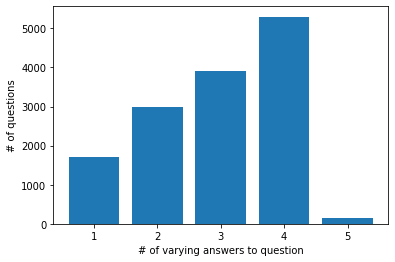

In [18]:
# plot answer variety
plt.bar(attr, freqs)
plt.ylabel('# of questions')
plt.xlabel('# of varying answers to question')
plt.show()

Here, we see that there are quite a lot of questions for which the 10 answers differ, however, not more than 5 persons differing on a question answer. This suggests that the questions are of some complexity that is not trivial - however, it is hard to conclude anything for sure on this investigation since differing answers might simply be due to synonyms or similar phrasings. Let's try accounting for this using synsets (semantics) and redo the calculation!

In [19]:
# TODO: synset implementation!

Let's wrap all these initial investigations up in a dataframe with the question and answer attributes. We will now try to do further conditionalized experiments based on these.

In [20]:
QA = okvqa_full[['question_str', 'question_tokens', 'answers']].copy()
QA['question_length'] = QA.question_tokens.apply(lambda x: x.__len__())
QA['answer_length'] = QA.answers.apply(lambda answer: np.mean([subanswer.split(" ").__len__() for subanswer in answer]))
QA['answer_var'] = QA.answers.apply(lambda x: np.unique(x).__len__())

QA.head()

,question_str,question_tokens,answers,question_length,answer_length,answer_var
0,What is the hairstyle of the blond called?,"[what, is, the, hairstyle, of, the, blond, cal...","[pony tail, pony tail, pony tail, pony tail, p...",8,1.6,3
1,How old do you have to be in canada to do this?,"[how, old, do, you, have, to, be, in, canada, ...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]",12,1.0,1
2,Can you guess the place where the man is playing?,"[can, you, guess, the, place, where, the, man,...","[aspen, aspen, mountain, mountain, mountain, m...",10,1.2,4
3,Which rail company is named after a town in ne...,"[which, rail, company, is, named, after, a, to...","[santa fe, santa fe, santa fe, santa fe, new e...",11,1.8,4
4,Is the boy swimming or doing another water act...,"[is, the, boy, swimming, or, doing, another, w...","[another activity, another activity, another a...",9,1.4,4


#### TODO: investigate question complexity
TODO: qualitatively analyze the outliers - some of them are quite stupid.

#### TODO: investigate ambiguity?
Semantic and syntactic information (use PoS-tags)
Ambiguity metric? Search for word tokens in a dictionary of probable tags? Maybe even use probability scores if they are available (if one word has two possible tags that are 50/50 to occur, then the ambiguity score should be high).

TODO: Answer variability - map synsets to it!

#### TODO: conditional investigations - what is the uncertainty/ambiguity for answers depending on the question length?
Maybe a statistical test?


Let's visualize the questions in a bit more intuitive fashion. Try interacting with the plots below - you can hover the areas or press them if you like!

In [29]:
N = 251
visualization_depth = 15

temp = createSunburstVariables(okvqa['trainval'], N)
plotSunburst(temp, N, visualization_depth=visualization_depth, use_dash=False)

In [24]:
N = 51
visualization_depth = 15

temp = createSunburstVariables(okvqa['test'], N)
plotSunburst(temp, N, visualization_depth, use_dash=False)

In [25]:
N = 51
visualization_depth = 15

temp = createSunburstVariables(okvqa_full, N)
plotSunburst(temp, N, visualization_depth, use_dash=False)

Deploy dash app in webpage: https://dash.plotly.com/deployment

## 4) Images

In [27]:
# Load features
data_path = Path.home() / '.cache/torch/mmf/data/datasets/okvqa/defaults/images'

if alberts_sisters_computer:
    data_path = Path('/Users/Olivia/Desktop/albert/images')


In [ ]:
# image classification
# image shape?
# image quality?
# metric for perceptual information in image?

In [ ]:
#TODO: do these things for train/test split respectively! Maybe irrelevant if we use their pre-defined split?

In [ ]:
#Question: how should we deal with the bias there is that most questions start with 'what'? Guess that is not what the project is about